# Hate speech detection usig LSTM

*used dataset -> https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset/data*

In [1]:
# importing libraries
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/labeled_data.csv')

In [3]:
df.shape

(24783, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [6]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [10]:
# deleting unwanted columns
df.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],
        inplace = True)

In [11]:
# checking the null values
df.isnull().sum()

,0
class,0
tweet,0


In [12]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [13]:
df['tweet'].iloc[1000]

'&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@betysweetcocker: That pussy is just....&#128561; imma assume she just had a baby like..the day before"'

In [14]:
# removing unwanted symbols and numeric data
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [16]:
df['processed_tweet'].iloc[1000]

'                                                                 betysweetcocker  That pussy is just              imma assume she just had a baby like  the day before '

In [17]:
# removing unwanted spaces
df['processed_tweet'] = df['processed_tweet'].str.replace(r'[\s]+',' ', regex = True)

In [18]:
df['processed_tweet'].iloc[1000]

' betysweetcocker That pussy is just imma assume she just had a baby like the day before '

In [19]:
# NLP
nlp = spacy.load('en_core_web_sm')

In [20]:
# lemmatization
def lemmatization(text):
  doc = nlp(text)
  lemmalist = [word.lemma_ for word in doc]
  return ' '.join(lemmalist)

In [21]:
df['lemma_tweet'] = df['processed_tweet'].apply(lemmatization)

In [22]:
df.head()

,class,tweet,processed_tweet,lemma_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...


In [25]:
df['processed_tweet'].iloc[155]

' KazAtta TAKEHOV Oh man its am you off a molly ho where the fuck ya seed at fixed'

In [26]:
df['lemma_tweet'].iloc[155]

'  KazAtta TAKEHOV oh man its be you off a molly ho where the fuck ya seed at fix'

In [27]:
# REMOVING STOPWORDS
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [28]:
df.head()

,class,tweet,processed_tweet,lemma_tweet,final_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...,RT mayasolovely woman shouldn t complain cl...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad cuffin d...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...,RT UrKindOfBrand Dawg RT sbaby life fuck bi...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...,RT C G Anderson viva base look like tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...,RT ShenikaRoberts shit hear true faker bitc...


In [30]:
df['final_tweet'].iloc[155]

'   KazAtta TAKEHOV oh man molly ho fuck ya seed fix'

In [31]:
# ONE - HOT REPRESENTATION

vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df['final_tweet']]

In [32]:
one_hot_representation[155]

[2701, 2054, 6660, 9242, 9834, 7471, 5315, 4876, 1505, 6366]

In [33]:
# PADDING AND EMBEDDING
sentence_lenght = 20
embedded_tweet = pad_sequences(one_hot_representation, padding = 'pre', maxlen = sentence_lenght)


In [34]:
# DIVIDING THE DATASET
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [35]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [36]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [37]:
# TRAIN - TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [39]:
# CREATING MODEL

dimension = 50

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size, dimension, input_length = sentence_lenght),
    # LSTM layer
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    #output layer
    keras.layers.Dense(3, activation = 'softmax')
])

#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(X_train, y_train, epochs = 10, batch_size=32)


Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7735 - loss: 0.5083
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9434 - loss: 0.1739
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9609 - loss: 0.1230
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9726 - loss: 0.0928
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9795 - loss: 0.0712
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9829 - loss: 0.0552
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9873 - loss: 0.0399
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9903 - loss: 0.0282
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9933 - loss: 0.0202
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9954 - loss: 0.0159


In [42]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8923 - loss: 0.5999
Model Accuracy : 88.74133229255676


In [43]:
pred = np.argmax(model.predict(X_test), axis = -1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [44]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [45]:
pred[:5]

array([1, 1, 0, 1, 2])

In [46]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3812
           1       0.90      0.91      0.90      3807
           2       0.72      0.73      0.73       890

    accuracy                           0.89      8509
   macro avg       0.84      0.85      0.85      8509
weighted avg       0.89      0.89      0.89      8509



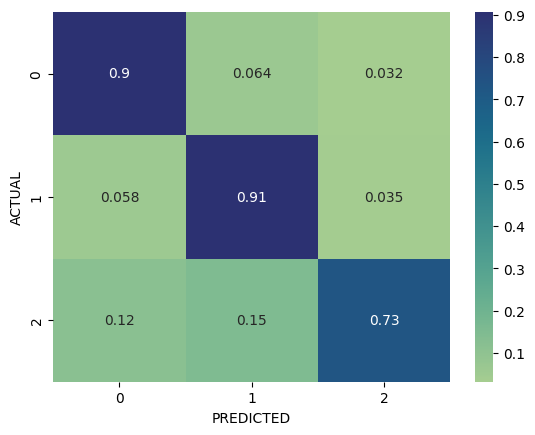

In [47]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');

In [55]:

model.save('hate_speech_detection_model.h5')


In [53]:
import numpy as np
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import spacy

# Load spaCy language model
nlp = spacy.load("en_core_web_sm")

vocab_size = 10000
sentence_length = 20


def predict_category(text):
    # Preprocess the input text
    processed_text = text.lower()
    processed_text = re.sub(r'[^a-zA-Z]', ' ', processed_text)  # Remove non-alphabetic chars
    processed_text = re.sub(r'\s+', ' ', processed_text)  # Remove extra spaces

    # Lemmatization
    doc = nlp(processed_text)
    lemmalist = [word.lemma_ for word in doc]
    lemmatized_text = ' '.join(lemmalist)

    # Removing stopwords
    doc = nlp(lemmatized_text)
    no_stopwords_list = [word.text for word in doc if not word.is_stop]
    processed_text = ' '.join(no_stopwords_list)

    # One-hot encode and pad the processed text
    one_hot_rep = one_hot(processed_text, vocab_size)
    padded_text = pad_sequences([one_hot_rep], padding='pre', maxlen=sentence_length)

    # Make the prediction
    prediction = np.argmax(model.predict(padded_text), axis=-1)

    # Return the predicted category
    categories = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
    return categories.get(prediction[0], "Unknown")

# Example usage
sample_sentences = [
    "I hate you",
    "You are ass",
    "This is a nice day",
    "How are u?",
    "Kill them all"
]

for sentence in sample_sentences:
    predicted_category = predict_category(sentence)
    print(f"Sentence: '{sentence}' --> Predicted Category: {predicted_category}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sentence: 'I hate you' --> Predicted Category: Hate Speech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sentence: 'You are ass' --> Predicted Category: Offensive Language
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sentence: 'This is a nice day' --> Predicted Category: Neither
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sentence: 'How are u?' --> Predicted Category: Neither
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Sentence: 'Kill them all' --> Predicted Category: Hate Speech
